<a href="https://colab.research.google.com/github/Anurag38/CECS550-Pattern-Recognition/blob/main/HW4/HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys

# Build a Variational Autoencoder (VAE) for a human face dataset

We will use a dataset containing images of people and train a variational autoencoder on it.

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!unzip '/content/drive/MyDrive/CECS550/HW3/lfw.zip'

Streaming output truncated to the last 5000 lines.
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0021.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0021.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0020.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0020.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0008.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0008.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0022.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0022.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0023.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0023.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0012.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0012.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep

In [6]:
path = '/content/lfw'

In [9]:
transform    = transforms.Compose([transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)

This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [10]:
# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("GPU not available. Using CPU.")

Using GPU: Tesla T4


torch.Size([250, 250, 3])


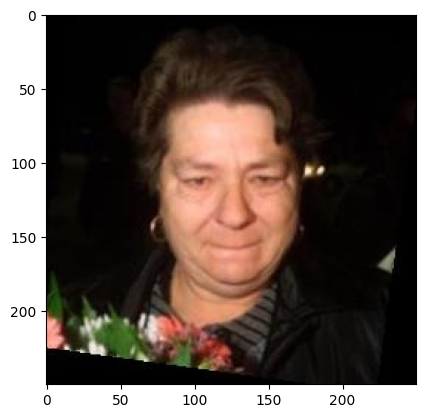

In [11]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

# Step 2
The basis for this project is that you can alter your implementation of AutoEncoders from the previous homework and add the necessary bits for a VAE.  Clearly state what is the difference between AutoEncoders and VAEs in terms of Applications, Architecture and Loss function.

#### **Autoencoders (AEs)**

*   Applications : Unsupervised learning, dimensionality reduction, data denoising, feature learning.
*   Architecture : Encoder compresses input, decoder reconstructs output.
*   Loss Function : Typically Mean Squared Error (MSE) for reconstruction.

**Variational  Autoencoders (AEs)**

*   Applications : Data generation, image synthesis, style transfer, anomaly detection.
*   Architecture : Encoder encodes data into a probabilistic distribution in latent space, decoder reconstructs output.
*   Loss Function : Reconstruction loss (MSE) plus a regularization term (KL divergence) to shape the latent space.




# Step 3

Update your pytorch autoencoder model class to create your VAE. Assume the encoder produces the mean and log variance of the latent space.  

**Create separate functions for the encoder and decoder.**

In [29]:
import torch.nn.functional as F

class VAE(nn.Module):

    def __init__(self, latent_dim):
        super(VAE, self).__init__()

        self.latent_dim = latent_dim

        self.encoder_conv = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.fc_mu = nn.Linear(256 * 31 * 31, latent_dim)
        self.fc_log_var = nn.Linear(256 * 31 * 31, latent_dim)

        # Decoder
        self.decoder_fc = nn.Linear(latent_dim, 256 * 31 * 31)
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(3),
            nn.Sigmoid()
        )

    def encoder(self, x):
        x = self.encoder_conv(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        log_var = self.fc_log_var(x)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decoder(self, x):
        x = self.decoder_fc(x)
        x = x.view(x.size(0), 256, 31, 31)
        x = self.decoder_conv(x)
        x = F.interpolate(x, size=(250, 250), mode='bilinear', align_corners=False)
        return x

    def forward(self, x):
        # Encoder
        mu, log_var = self.encoder(x)

        # Reparameterization
        z = self.reparameterize(mu, log_var)

        # Decoder
        x_recon = self.decoder(z)

        return x_recon, mu, log_var

# Variational Autoencoder (VAE) Architecture

## Overview
This is the implementation of a Variational Autoencoder (VAE) using PyTorch. A VAE is a generative model that learns a probabilistic mapping between input data and a latent space, allowing for the generation of new samples.

## Architecture Details

### Encoder
- The encoder takes input images (3 channels) and passes them through convolutional layers.
- Convolutional layers with batch normalization and ReLU activation are used for feature extraction.
- The output is then flattened and passed through two linear layers (`fc_mu` and `fc_log_var`) to obtain the mean (`mu`) and log-variance (`log_var`) of the latent space.

### Reparameterization Trick
- The reparameterization trick is applied to sample from the latent space. It introduces a stochastic element by sampling from a normal distribution defined by the mean and log-variance obtained from the encoder.

### Decoder
- The decoder takes the sampled latent vector and reconstructs the original image.
- Linear layer (`decoder_fc`) is used to reshape the latent vector.
- Convolutional transpose layers with batch normalization and ReLU activation are used for upsampling and generating the reconstructed image.
- The final layer uses Sigmoid activation to ensure the pixel values are in the range [0, 1].

### Forward Pass
- The forward pass involves encoding the input image, applying the reparameterization trick, and then decoding to reconstruct the input.

## Architecture Summary
- Input: RGB images (3 channels)
- Latent Dimension: Specified during initialization
- Loss Function: Typically includes a reconstruction loss and a regularization term based on the Kullback-Leibler (KL) divergence.

## Usage
Instantiate the VAE model with a desired latent dimension:
```python
vae_model = VAE(latent_dim=20)


## Step 4
Create an instance of the new class, pass an image to the model

*  print the shape of the output of the **encoder**. Explain how would you generate new samples in the latent space. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.
*  use the decoder to create new images. Print the shape of the output and verify that the forward pass is working correctly.

In [30]:
model = VAE(latent_dim=50).to(device)

In [31]:
# Pass an image to the model
input_image = x.permute(2, 0, 1).unsqueeze(0).to(device)

# Forward pass through the VAE
output_image, mu, log_var = model(input_image)

# Print the shape of the output of the encoder
print("Encoder Output Dimension: ", mu.shape)
print("Log Variance : ", log_var.shape)

# Sample from the latent space
z_sampled = model.reparameterize(mu, log_var)

# Use the decoder to generate new images from the sampled latent space
generated_image = model.decoder(z_sampled)

# Print the shape of the output of the decoder
print("Decoder Output Dimension:", generated_image.shape)

Encoder Output Dimension:  torch.Size([1, 50])
Log Variance :  torch.Size([1, 50])
Decoder Output Dimension: torch.Size([1, 3, 250, 250])


#### Generating new samples in the latent space involves working with a generative model, such as a Variational Autoencoder (VAE) or a Generative Adversarial Network (GAN).




1.   Sample from the learned probability distribution in the latent space using the reparameterization trick.

```
z = z_mean + z_stddev * epsilon
```
* Here z_mean and z_stddev is the output obtained from the encoder
* The sampled latent vector z is obtained by adding the mean ```z_mean``` to the product of the standard deviation ```z_stddev``` and a random sample ```epsilon``` from a standard normal distribution. This introduces randomness into the latent space.

2.   Pass the sampled latent vector through the decoder to obtain a new data point.

```
generated_output = decoder(z)
```

* The sampled latent vector is passed through the decoder, which reconstructs the output ```generated_output```. This output represents a new data point generated from the learned latent space distribution.




##  Step 5
* Print the total number of parameters in the model
* Explain what loss should be used here. Describe in your own words the terms of the loss function and what goal each term of the loss function achieves. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.


* create an optimizer for training

In [32]:
total_params_vae = sum(p.numel() for p in model.parameters())
print(f"Total Number of Parameters in VAE: {total_params_vae}")

Total Number of Parameters in VAE: 38467309


In [16]:
optim = torch.optim.Adam(model.parameters(), lr=0.001)

In [17]:
input_image = F.interpolate(input_image, size=(250, 250), mode='bilinear', align_corners=False).to(device)

# Reconstruction Loss:
reconstruction_loss = F.mse_loss(output_image, input_image, reduction='sum')

# KL Divergence Loss:
kl_divergence_loss = -1 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

# Total Loss:
loss_function = (reconstruction_loss + kl_divergence_loss)

1.   **reconstruction_loss**

* ```reconstruction_loss = F.mse_loss(output_image, input_image_resized, reduction='sum'```

* The ```reconstruction_loss``` term is calculated using Mean Squared Error (MSE) loss. It measures the difference between the output of the VAE ```output_image``` and the resized input image ```input_image```. The reduction='sum' parameter indicates that the MSE losses for individual pixels are summed to obtain a single scalar value.

2.   **kl_divergence_loss**

* ```kl_divergence_loss = -1 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())```

* The ```kl_divergence_loss``` term calculates the Kullback-Leibler (KL) divergence between the learned distribution in the latent space (parameterized by ```mu``` and ```log_var```) and a standard normal distribution. The formula used corresponds to the KL divergence formula for a Gaussian distribution. The negative sign is applied since the standard practice is to minimize the negative KL divergence.

3. **loss_function**

* ```loss_function = (reconstruction_loss + kl_divergence_loss)```

* The ```loss_function``` is the sum of the ```reconstruction_loss``` and the ```kl_divergence_loss```. This combination forms the total loss for the VAE. By summing these terms, the VAE aims to balance the goal of accurately reconstructing input data (```reconstruction_loss```) with the regularization of the latent space (```kl_divergence_loss```). The total loss guides the optimization process during training.




##  Step 6
Write a training loop and start training the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [28]:
num_epochs = 20

for epoch in range(num_epochs):
    total_recon_loss = 0.0
    total_kl_divergence_loss = 0.0
    total_loss = 0.0

    for images, _ in dataloader:
        # Resize input images to match the output size of the VAE
        images = F.interpolate(images, size=(250, 250), mode='bilinear', align_corners=False).to(device)
        images = images.to(device)
        # Forward pass
        output_images, mu, log_var = model(images)

        # recon Loss
        recon_loss = F.mse_loss(output_images, images, reduction='sum')

        # KL Divergence Loss
        kl_divergence_loss = -5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

        # Total Loss using predefined loss function:
        total_loss = (recon_loss + kl_divergence_loss)

        # Backward pass and optimization
        optim.zero_grad()
        total_loss.backward()
        optim.step()

        total_recon_loss += reconstruction_loss.item()
        total_kl_divergence_loss += kl_divergence_loss.item()

    average_recon_loss = total_recon_loss / len(dataloader)
    average_kl_divergence_loss = total_kl_divergence_loss / len(dataloader)
    average_total_loss = total_loss / len(dataloader)

    print(f'Total Loss: {average_total_loss:.5f}')

Total Loss: 242.25711
Total Loss: 201.08781
Total Loss: 236.91266
Total Loss: 222.23433
Total Loss: 245.07585
Total Loss: 217.56116
Total Loss: 226.24936
Total Loss: 212.53229
Total Loss: 245.79202
Total Loss: 229.54076
Total Loss: 239.69173
Total Loss: 233.72644
Total Loss: 233.11090
Total Loss: 215.91168
Total Loss: 218.12671
Total Loss: 241.63145
Total Loss: 243.78606
Total Loss: 247.86412
Total Loss: 238.28500
Total Loss: 194.40648


# VAE Training Loop

## Overview
This code snippet represents a training loop for a Variational Autoencoder (VAE) model. The VAE is a generative model that learns a probabilistic mapping between input data and a latent space, allowing for the generation of new samples.

## Training Loop Details

### Epoch Iteration
The training loop iterates over a specified number of epochs (`num_epochs`), and within each epoch, it processes batches of data from a given data loader (`dataloader`).

### Forward Pass
- Input images are resized to match the specified output size of the VAE using bilinear interpolation.
- The model is then used to perform a forward pass, generating reconstructed images (`output_images`), as well as the mean (`mu`) and log-variance (`log_var`) of the latent space.

### Loss Computation
- **Reconstruction Loss (`recon_loss`):** Computed using Mean Squared Error (MSE) loss between the output images and the input images.
- **KL Divergence Loss (`kl_divergence_loss`):** Computed based on the Kullback-Leibler (KL) divergence between the learned distribution in the latent space and the standard normal distribution.

### Total Loss
The total loss is calculated as the sum of the reconstruction loss and the KL divergence loss.

### Backward Pass and Optimization
- Gradients are zeroed (`optim.zero_grad()`).
- The total loss is backpropagated through the network (`total_loss.backward()`).
- Optimizer is updated to adjust the model's parameters (`optim.step()`).

### Loss Tracking
- Total reconstruction loss, KL divergence loss, and total loss are accumulated over batches.
- Averages are computed for each loss type per epoch.

### Logging
The average losses for each epoch are printed, providing insight into the training progress.

## Usage
This code is typically used within a larger script or program for training a VAE on a specific dataset.

```python
num_epochs = 20

for epoch in range(num_epochs):
    # ... (Training loop code)
    print(f'Epoch [{epoch + 1}/{num_epochs}] - Recon Loss: {average_recon_loss:.5f}, KL Div Loss: {average_kl_divergence_loss:.5f}, Total Loss: {average_total_loss:.5f}')


##  Step 7

Take a random image from the dataset and plot it together with new samples generated.

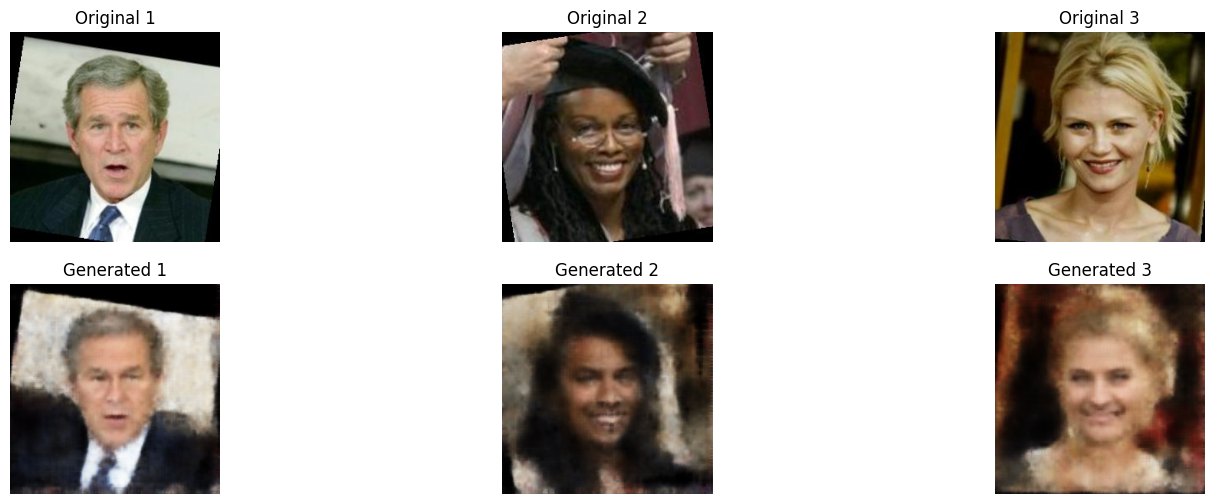

In [40]:
import random
import torch
import matplotlib.pyplot as plt

# Choose 3 random indices from the dataset
random_indices = random.sample(range(len(dataloader.dataset)), 3)

# Get the corresponding images for the selected indices
random_images = [dataloader.dataset[index][0] for index in random_indices]

# Move the random images to the GPU
random_images = [image.unsqueeze(0).to(device) for image in random_images]

# Initialize an empty list to store encoded representations
encoded_images = []

# Generate the encoded representations of the random images
with torch.no_grad():
    for random_image in random_images:
        mu, log_var = model.encoder(random_image)
        encoded_image = model.reparameterize(mu, log_var)
        encoded_images.append(encoded_image)

# Plot the original random images
plt.figure(figsize=(18, 6))

for i in range(3):
    plt.subplot(2, 3, i + 1)
    plt.imshow(random_images[i].squeeze().cpu().numpy().transpose(1, 2, 0))
    plt.title(f"Original {i+1}")
    plt.axis('off')

# Plot the generated samples from the encoded images
num_samples = 1  # Number of samples to generate

for i in range(3):
    with torch.no_grad():
        generated_samples_from_encoded = model.decoder(encoded_images[i])

    generated_samples_from_encoded_cpu = generated_samples_from_encoded.cpu()

    plt.subplot(2, 3, i + 4)
    plt.imshow(generated_samples_from_encoded_cpu.squeeze().numpy().transpose(1, 2, 0))
    plt.title(f"Generated {i+1}")
    plt.axis('off')

plt.show()

#### Reference


*   [Article](https://towardsdatascience.com/variational-autoencoder-55b288f2e2e0?source=-----55b288f2e2e0---------------------post_regwall-----------&skipOnboarding=1&gi=87c3fe5113c0)
*   ChatGPT

